# Optimization and robustness testing

In this notebook, the optimization and robustness testing will be performed.

First the model will be loaded. Loading of the model proceeds differently from the other notebooks, because the model is optimized over the outcome values. Due to the stochasticity of the Netlogo model, the model outcome value consists of 50 individual run values. The built-in optimization of the EMA workbench does not have a function to deal with this. Therefore, the model function that is called is a Python file that calls the Netlogo model, runs it 50 times and reports back the average value of the 50 runs. Model loading thus proceeds via this Python file. 

In [ ]:
#Import the EMA workbench
from ema_workbench import (Model, RealParameter, TimeSeriesOutcome, perform_experiments, ema_logging, Scenario)
from ema_workbench.em_framework.optimization import (HyperVolume,
                                                     EpsilonProgress)
from ema_workbench.connectors.netlogo import NetLogoModel
from ema_workbench import MultiprocessingEvaluator
from ema_workbench.em_framework.evaluators import LHS, SOBOL, MORRIS
import ema_workbench
import jpype


__all__ = ['NetLogoLink',
           'NetLogoException']

from ema_workbench import (Constant, TimeSeriesOutcome, IntegerParameter, RealParameter, BooleanParameter, ScalarOutcome, ema_logging, perform_experiments, ArrayOutcome, Policy)
from ema_workbench.connectors import netlogo
from ema_workbench.connectors.netlogo import NetLogoModel
from ema_workbench import save_results

#Import the other packages
import import_ipynb
import numpy as np
import pandas as pd
import Netlogo_model_python
import pickle
import matplotlib.pyplot as plt
import seaborn as sns


In [ ]:
#Import the netlogo model from the Python file
model = Model('pyNetlogoModel', function=Netlogo_model_python.netlogo_repeat_model_2)

In [ ]:
ema_logging.log_to_stderr(ema_logging.INFO)

#Define the outcomes to optimize over
outcomes = [
        ScalarOutcome('NOP_products_end_user', kind=ScalarOutcome.MINIMIZE, expected_range=(0,20)),
        ScalarOutcome('mean_pct_illegal', kind=ScalarOutcome.MINIMIZE, expected_range=(0,30))
           ]

#Define the NetLogo model

model.uncertainties = [IntegerParameter('pct_AC_end_users', 0, 100),
                         RealParameter('pct_AC_traders', 0, 100),
                         RealParameter('pct_Traders_EUO', 10, 90),
                         RealParameter('pct_coverage', 10, 100),
                         IntegerParameter('min_prof', 0, 5000), 
                         IntegerParameter('inspection_chance_NL_border', 0, 50),
                           ]
                         
model.outcomes = outcomes

model.levers = [ IntegerParameter('nr_PPPs_insp_trader', 1, 50),
                 IntegerParameter('insp_EUO_traders', 0, 1),
                 IntegerParameter('insp_TTTO_traders', 0, 1),
                 IntegerParameter('nr_of_inspectors', 1, 10),
                 RealParameter('pct_profiling', 0, 100) ]

#Define the convergence metrics
convergence_metrics = [HyperVolume.from_outcomes(model.outcomes),
                       EpsilonProgress()]

#Define the reference scenario
reference = Scenario('reference', pct_AC_end_users = 70, pct_AC_traders = 50, pct_Traders_EUO=70, pct_coverage=70, min_prof = 3000, inspection_chance_NL_border = 10)

With the model defined, the optimization can be run. For the optimization, first a 1000 function evaluations will be run with an epsilon of 1 to check if the optimization converges. 

In [15]:
#Perform the optimization
if __name__ == '__main__':

    with MultiprocessingEvaluator(model) as evaluator:
        results, convergence = evaluator.optimize(searchover = 'levers',reference = reference, convergence=convergence_metrics,
                            nfe=1000, epsilons=[1,]*len(model.outcomes))

[MainProcess/INFO] pool started
[MainProcess/INFO] generation 0: 0/1000 nfe
[MainProcess/INFO] generation 5: 500/1000 nfe
[MainProcess/INFO] optimization completed, found 1 solutions
[MainProcess/INFO] terminating pool


In [16]:
#Save the results
a_file = open("Results/data_optimization.pkl", "wb")
pickle.dump(results, a_file)
a_file.close()

a_file = open("Results/data_optimization_convergence.pkl", "wb")
pickle.dump(convergence, a_file)
a_file.close()

With the results, we can plot the hypervolume and epsilon convergence.

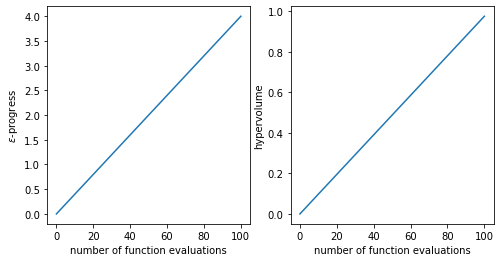

In [18]:
#Create plots of the epsilon convergence and hypervolume
fig, (ax1, ax2) = plt.subplots(ncols=2, sharex=True, figsize=(8,4))
ax1.plot(convergence.nfe, convergence.epsilon_progress)
ax1.set_ylabel('$\epsilon$-progress')
ax2.plot(convergence.nfe, convergence.hypervolume)
ax2.set_ylabel('hypervolume')

ax1.set_xlabel('number of function evaluations')
ax2.set_xlabel('number of function evaluations')
plt.show()

It appears as if the model does not converge with the current settings. Therefore the model is run with a higher number of function evaluations, namely 10000 and a lower epsilon, namely 0.5.

In [20]:
#Perform the optimization
if __name__ == '__main__':

    with MultiprocessingEvaluator(model) as evaluator:
        results, convergence = evaluator.optimize(searchover = 'levers',reference = reference, convergence=convergence_metrics,
                            nfe=10000, epsilons=[0.5,]*len(model.outcomes))

[MainProcess/INFO] pool started
[MainProcess/INFO] generation 0: 0/10000 nfe
[MainProcess/INFO] generation 5: 500/10000 nfe
[MainProcess/INFO] generation 10: 1000/10000 nfe
[MainProcess/INFO] generation 15: 1500/10000 nfe
[MainProcess/INFO] generation 20: 2000/10000 nfe
[MainProcess/INFO] generation 25: 2500/10000 nfe
[MainProcess/INFO] generation 30: 3000/10000 nfe
[MainProcess/INFO] generation 35: 3500/10000 nfe
[MainProcess/INFO] generation 40: 4000/10000 nfe
[MainProcess/INFO] generation 45: 4500/10000 nfe
[MainProcess/INFO] generation 50: 5000/10000 nfe
[MainProcess/INFO] generation 55: 5500/10000 nfe
[MainProcess/INFO] generation 60: 6000/10000 nfe
[MainProcess/INFO] generation 65: 6500/10000 nfe
[MainProcess/INFO] generation 70: 7000/10000 nfe
[MainProcess/INFO] generation 75: 7500/10000 nfe
[MainProcess/INFO] generation 80: 8000/10000 nfe
[MainProcess/INFO] generation 85: 8500/10000 nfe
[MainProcess/INFO] generation 90: 9000/10000 nfe
[MainProcess/INFO] generation 95: 9500/1000

In [21]:
#Save the results
a_file = open("Results/data_optimization_10.000.pkl", "wb")
pickle.dump(results, a_file)
a_file.close()

a_file = open("Results/data_optimization_convergence_10.000.pkl", "wb")
pickle.dump(convergence, a_file)
a_file.close()

In [22]:
#Show the results
results

,nr_PPPs_insp_trader,insp_EUO_traders,insp_TTTO_traders,nr_of_inspectors,pct_profiling,NOP_products_end_user,mean_pct_illegal
0,38,1,1,10,4.002272,0.08364,0.647402


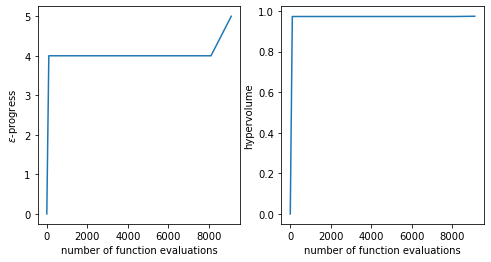

In [24]:
#Create plots of the epsilon convergence and hypervolume
fig, (ax1, ax2) = plt.subplots(ncols=2, sharex=True, figsize=(8,4))
ax1.plot(convergence.nfe, convergence.epsilon_progress)
ax1.set_ylabel('$\epsilon$-progress')
ax2.plot(convergence.nfe, convergence.hypervolume)
ax2.set_ylabel('hypervolume')

ax1.set_xlabel('number of function evaluations')
ax2.set_xlabel('number of function evaluations')
plt.show()

As it appears, the optimization rendered only one optimal policy. As robustness testing of only one policy does not allow for comparison between policies, seven new policies are defined.

In [8]:
#Check robustness of pre-defined policies
opened_results = pd.read_pickle("Results/data_optimization_10.000.pkl")
policies = opened_results.drop([o.name for o in model.outcomes], axis=1)
policies.loc[len(policies)] = [38, 1, 0, 10, 4]
policies.loc[len(policies)] = [38, 0, 1, 10, 4]
policies.loc[len(policies)] = [38, 0, 0, 10, 4]
policies.loc[len(policies)] = [38, 1, 1, 1, 4]
policies.loc[len(policies)] = [38, 1, 0, 1, 4]
policies.loc[len(policies)] = [38, 0, 1, 1, 4]
policies.loc[len(policies)] = [38, 0, 0, 1, 4]
policies

,nr_PPPs_insp_trader,insp_EUO_traders,insp_TTTO_traders,nr_of_inspectors,pct_profiling
0,38,1,1,10,4.002272
1,38,1,0,10,4.000000
2,38,0,1,10,4.000000
3,38,0,0,10,4.000000
4,38,1,1,1,4.000000
5,38,1,0,1,4.000000
6,38,0,1,1,4.000000
7,38,0,0,1,4.000000


In [9]:
#Make dictionaries of the policies to be able to use them in the robustness testing
policies_to_evaluate = []

for i, policy in policies.iterrows():
    policies_to_evaluate.append(Policy(str(i), **policy.to_dict()))
    
policies_to_evaluate

[Policy({'nr_PPPs_insp_trader': 38.0, 'insp_EUO_traders': 1.0, 'insp_TTTO_traders': 1.0, 'nr_of_inspectors': 10.0, 'pct_profiling': 4.002271904107579}),
 Policy({'nr_PPPs_insp_trader': 38.0, 'insp_EUO_traders': 1.0, 'insp_TTTO_traders': 0.0, 'nr_of_inspectors': 10.0, 'pct_profiling': 4.0}),
 Policy({'nr_PPPs_insp_trader': 38.0, 'insp_EUO_traders': 0.0, 'insp_TTTO_traders': 1.0, 'nr_of_inspectors': 10.0, 'pct_profiling': 4.0}),
 Policy({'nr_PPPs_insp_trader': 38.0, 'insp_EUO_traders': 0.0, 'insp_TTTO_traders': 0.0, 'nr_of_inspectors': 10.0, 'pct_profiling': 4.0}),
 Policy({'nr_PPPs_insp_trader': 38.0, 'insp_EUO_traders': 1.0, 'insp_TTTO_traders': 1.0, 'nr_of_inspectors': 1.0, 'pct_profiling': 4.0}),
 Policy({'nr_PPPs_insp_trader': 38.0, 'insp_EUO_traders': 1.0, 'insp_TTTO_traders': 0.0, 'nr_of_inspectors': 1.0, 'pct_profiling': 4.0}),
 Policy({'nr_PPPs_insp_trader': 38.0, 'insp_EUO_traders': 0.0, 'insp_TTTO_traders': 1.0, 'nr_of_inspectors': 1.0, 'pct_profiling': 4.0}),
 Policy({'nr_PPP

Now that the policies have been defined, the robustness of the policies can be tested. For this, the policies are tested over 200 scenarios.

In [10]:
n_scenarios = 200
with MultiprocessingEvaluator(model) as evaluator:
    results = evaluator.perform_experiments(n_scenarios,
                                            policies_to_evaluate)

[MainProcess/INFO] pool started
[MainProcess/INFO] performing 200 scenarios * 8 policies * 1 model(s) = 1600 experiments
[MainProcess/INFO] 160 cases completed
[MainProcess/INFO] 320 cases completed
[MainProcess/INFO] 480 cases completed
[MainProcess/INFO] 640 cases completed
[MainProcess/INFO] 800 cases completed
[MainProcess/INFO] 960 cases completed
[MainProcess/INFO] 1120 cases completed
[MainProcess/INFO] 1280 cases completed
[MainProcess/INFO] 1440 cases completed
[MainProcess/INFO] 1600 cases completed
[MainProcess/INFO] experiments finished
[MainProcess/INFO] terminating pool


In [12]:
#Save the results
experiments, outcomes = results

a_file = open("Results/experiments_robustness_8_policies.pkl", "wb")
pickle.dump(experiments, a_file)
a_file.close()

a_file = open("Results/outcomes_robustness_8_policies.pkl", "wb")
pickle.dump(outcomes, a_file)
a_file.close()

In [13]:
experiments

,inspection_chance_NL_border,min_prof,pct_AC_end_users,pct_AC_traders,pct_Traders_EUO,pct_coverage,nr_PPPs_insp_trader,insp_EUO_traders,insp_TTTO_traders,nr_of_inspectors,pct_profiling,scenario,policy,model
0,21.0,4706.0,48.0,37.450442,49.143330,11.212403,38.0,1.0,1.0,10.0,4.002272,0,0,pyNetlogoModel
1,20.0,2631.0,44.0,71.384813,62.000875,92.868867,38.0,1.0,1.0,10.0,4.002272,1,0,pyNetlogoModel
2,1.0,3749.0,31.0,70.250793,41.475659,32.862892,38.0,1.0,1.0,10.0,4.002272,2,0,pyNetlogoModel
3,46.0,1014.0,39.0,11.623042,74.810692,62.895823,38.0,1.0,1.0,10.0,4.002272,3,0,pyNetlogoModel
4,16.0,4587.0,29.0,74.572140,14.608007,77.620127,38.0,1.0,1.0,10.0,4.002272,4,0,pyNetlogoModel
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1595,26.0,4279.0,22.0,8.265132,23.416455,91.815477,38.0,0.0,0.0,1.0,4.000000,195,7,pyNetlogoModel
1596,33.0,4983.0,95.0,66.954022,23.955406,17.381265,38.0,0.0,0.0,1.0,4.000000,196,7,pyNetlogoModel
1597,3.0,989.0,30.0,88.942222,28.024820,38.343089,38.0,0.0,0.0,1.0,4.000000,197,7,pyNetlogoModel
1598,48.0,257.0,82.0,41.388967,46.599697,40.675238,38.0,0.0,0.0,1.0,4.000000,198,7,pyNetlogoModel


In [14]:
results

(      inspection_chance_NL_border  min_prof  pct_AC_end_users  pct_AC_traders  \
 0                            21.0    4706.0              48.0       37.450442   
 1                            20.0    2631.0              44.0       71.384813   
 2                             1.0    3749.0              31.0       70.250793   
 3                            46.0    1014.0              39.0       11.623042   
 4                            16.0    4587.0              29.0       74.572140   
 ...                           ...       ...               ...             ...   
 1595                         26.0    4279.0              22.0        8.265132   
 1596                         33.0    4983.0              95.0       66.954022   
 1597                          3.0     989.0              30.0       88.942222   
 1598                         48.0     257.0              82.0       41.388967   
 1599                         33.0    4840.0              35.0       80.256774   
 
       pct_Tra

Next, the robustness metrics can be calculated and results can be plotted. The robustness metrics that are used are the mean and standard deviation of the model outcomes for the policies over the scenarios and the worst performance in any of the scenarios.

In [3]:
#Load the results
opened_results = pd.read_pickle("Results/outcomes_robustness_8_policies.pkl")
opened_experiments = pd.read_pickle("Results/experiments_robustness_8_policies.pkl")

In [13]:
#Append the outcomes to the scenarios
opened_experiments["NOP_products_end_user"] = opened_results.get("NOP_products_end_user")
opened_experiments["mean_pct_illegal"] = opened_results.get("mean_pct_illegal")

In [95]:
#Calculate the mean and standard deviation of the model results
results_df = pd.DataFrame(columns = ["mean_NOP", "std_NOP", "mean_illegal", "std_illegal"])

#Per policy calculate the mean and standard deviation and append them to a dataframe
for i in opened_experiments["policy"].unique():
    results_policy = opened_experiments[opened_experiments["policy"] == i ]
    result_list = []
    result_list.append(results_policy["NOP_products_end_user"].mean())
    result_list.append(results_policy["NOP_products_end_user"].std())
    result_list.append(results_policy["mean_pct_illegal"].mean())
    result_list.append(results_policy["mean_pct_illegal"].std())
    df_length = len(results_df)
    results_df.loc[df_length] = result_list
results_df.index.name = "Policy"
results_df = results_df.round(decimals = 2)
results_df

,mean_NOP,std_NOP,mean_illegal,std_illegal
Policy,,,,
0,0.29,0.32,2.67,4.10
1,0.43,0.44,2.94,4.26
2,5.68,5.78,14.29,14.89
3,10.24,8.43,20.85,17.97
4,0.77,0.73,4.42,5.34
5,1.03,0.89,4.52,5.43
6,5.45,5.33,14.11,14.27
7,10.30,8.30,21.19,17.99


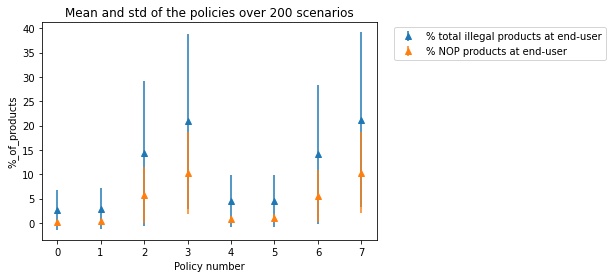

In [105]:
#Plot the results
#Plot the two outcome measures (NOP products and total percentage illegal products) in one graph
a = plt.errorbar(results_df.index, results_df["mean_illegal"], results_df["std_illegal"], linestyle='None', marker='^')
b = plt.errorbar(results_df.index, results_df["mean_NOP"], results_df["std_NOP"], linestyle='None', marker='^')

plt.xlabel("Policy number")
plt.ylabel("%_of_products")
plt.title("Mean and std of the policies over 200 scenarios")
plt.legend([a, b], ["% total illegal products at end-user", "% NOP products at end-user"], bbox_to_anchor=(1.7, 1))
plt.show()

In [ ]:
#Find the scenarios in which the policies perform worst 
#in terms of the maximum percentage of NOP products that reach the end-user
results_df = pd.DataFrame(columns = ["max_NOP"])
experiments_df = pd.DataFrame(columns = ["inspection_chance_NL_border", "min_prof", "pct_AC_end_users", "pct_AC_traders", "pct_Traders_EUO", "pct_coverage", "nr_PPPs_insp_trader", "insp_EUO_traders", "insp_TTTO_traders", "nr_of_inspectors", "pct_profiling", "scenario", "policy", "model", "NOP_products_end_user", "mean_pct_illegal"])

for i in opened_experiments["policy"].unique():
    results_policy = opened_experiments[opened_experiments["policy"] == i ]
    result_list = []
    
    #Find the highest percentage of NOP products reaching the end-user
    max_NOP = max(results_policy["NOP_products_end_user"])
    result_list.append(max_NOP)
    
    #Find the corresponding scenario
    scenario = results_policy[results_policy["NOP_products_end_user"] == max_NOP]
    experiments_df = pd.concat([experiments_df, scenario], axis = 0)
    df_length = len(results_df)
    results_df.loc[df_length] = result_list
    
#Create a dataframe of the results
experiments_df = experiments_df.reset_index()
results_df = pd.concat([results_df, experiments_df], axis = 1)
results_df.index.name = "Policy"
results_df = results_df.round(decimals = 2)
results_df = results_df.drop(["index", "policy", "scenario", "model", "nr_PPPs_insp_trader", "pct_profiling", "NOP_products_end_user", "mean_pct_illegal", "insp_EUO_traders", "insp_TTTO_traders", "nr_of_inspectors"], axis = 1)
results_df

In [106]:
#Find the scenarios in which the policies perform worst 
#in terms of the total percentage of illegal products that reach the end-user
results_df = pd.DataFrame(columns = ["max_illegal"])
experiments_df = pd.DataFrame(columns = ["inspection_chance_NL_border", "min_prof", "pct_AC_end_users", "pct_AC_traders", "pct_Traders_EUO", "pct_coverage", "nr_PPPs_insp_trader", "insp_EUO_traders", "insp_TTTO_traders", "nr_of_inspectors", "pct_profiling", "scenario", "policy", "model", "NOP_products_end_user", "mean_pct_illegal"])

for i in opened_experiments["policy"].unique():
    results_policy = opened_experiments[opened_experiments["policy"] == i ]
    result_list = []
    
    #Find the highest percentage of illegal products reaching the end-user
    max_illegal = max(results_policy["mean_pct_illegal"])
    result_list.append(max_illegal)
    
    #Find the corresponding scenario
    scenario = results_policy[results_policy["mean_pct_illegal"] == max_illegal]
    experiments_df = pd.concat([experiments_df, scenario], axis = 0)
    df_length = len(results_df)
    results_df.loc[df_length] = result_list
    
#Create a dataframe of the results
experiments_df = experiments_df.reset_index()
results_df = pd.concat([results_df, experiments_df], axis = 1)
results_df.index.name = "Policy"
results_df = results_df.round(decimals = 2)

results_df = results_df.drop(["index", "policy", "scenario", "model", "nr_PPPs_insp_trader", "pct_profiling", "NOP_products_end_user", "mean_pct_illegal", "insp_EUO_traders", "insp_TTTO_traders", "nr_of_inspectors"], axis = 1)
results_df

,max_illegal,inspection_chance_NL_border,min_prof,pct_AC_end_users,pct_AC_traders,pct_Traders_EUO,pct_coverage
Policy,,,,,,,
0,18.49,7.0,2668.0,16.0,97.72,83.97,11.89
1,17.92,18.0,3851.0,4.0,53.37,42.90,15.30
2,65.45,6.0,1066.0,1.0,27.65,47.23,16.45
3,70.32,41.0,1260.0,2.0,6.49,22.08,15.57
4,22.78,24.0,563.0,33.0,11.29,81.72,18.87
5,25.61,24.0,563.0,33.0,11.29,81.72,18.87
6,59.62,6.0,1066.0,1.0,27.65,47.23,16.45
7,70.86,41.0,1260.0,2.0,6.49,22.08,15.57
